# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# !pip install geopy
from geopy.distance import geodesic

In [2]:
train = pd.read_csv('../data/train.csv')
spray = pd.read_csv('../data/spray.csv')
weather = pd.read_csv('../data/weather.csv', na_values=["M", "  T", " ", "-"])

mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")

In [3]:
def plot_map():
  fig, ax = plt.subplots(figsize=(10,14), dpi=150)
  plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=(-88, -87.5, 41.6, 42.1))
  return

# Data Cleaning

We will assume that all duplicate entries are either data collected at different times of the day or an additional entry to that was segregated.

Also we will assume that if West Nile Virus is found in one of the entries, then it is present in that area (i.e. we will change all WnvPresent to True if at least one of them if True.

We will only add them together if the species are the same as we'd like to see which species

In [4]:
def clean_train(train_data):
    return (train_data
 [['Date','Species','Trap','Latitude','Longitude','NumMosquitos','WnvPresent']]
 .assign(Date = pd.to_datetime(train_data.Date))
 .astype({'Species':'category', 'Trap':'category','NumMosquitos':'int8','WnvPresent':'int8'})
 .groupby(by=['Date','Species','Trap'])
 .agg({
      'Latitude':np.mean,
      'Longitude':np.mean,
      'NumMosquitos':np.sum, #This is to add up the number of mosquitos
      'WnvPresent':np.max})
 .dropna()
 .sort_values(['Date','Trap'])
 .reset_index()
 .astype({'NumMosquitos':'int16','WnvPresent':'int8'})
)

In [5]:
def weather_clean(df_weather):
    return (df_weather
     [['Station','Date','Tmax','Tmin','Tavg', 'Depart', 'DewPoint','CodeSum','PrecipTotal']]
     .assign(Date=pd.to_datetime(df_weather['Date']),
         Latitude=df_weather['Station'].map(lambda x:41.995 if x==1 else 41.786), # Station 1's coordinates (Lat: 41.995, Long: -87.933), Station 2's coordinates (Lat: 41.786, Long: -87.752)
         Longitude=df_weather['Station'].map(lambda x:-87.933 if x==1 else -87.752),
         Tavg=df_weather['Tavg'].map(lambda x: np.nan if x=='M' else x).ffill(),
         Depart=df_weather['Depart'].map(lambda x: np.nan if x=='M' else x).ffill(),
         PrecipTotal=df_weather['PrecipTotal'].map(lambda x: 0 if x=='  T' else x).map(lambda x: np.nan if x=='M' else x).ffill())
     .astype({'Station':'category','Tmax':'int8','Tmin':'int8','Tavg':'int8','Depart':'int8','PrecipTotal':'float32', 'DewPoint':'int8'})
     .join(df_weather['CodeSum'].str.get_dummies(sep=' ')) # Dummify the weather codes
     .drop('CodeSum', axis = 1)
    )

def join_stations(df_weather):
  df_station1 = df_weather[df_weather['Station']==1]
  df_station2 = df_weather[df_weather['Station']==2]
  df_station1.set_index('Date', inplace=True)
  df_station2.set_index('Date',inplace=True)
  df_weather2 = df_station1.join(df_station2, rsuffix='2')
  df_weather3 = df_weather2.rolling(9).mean()
  return df_weather3.drop(columns=['Station','Station2'])

# EDA for Spray

In [6]:
spray.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [7]:
spray.groupby(by='Date').count()

Time  Latitude  Longitude
Date                                 
2011-08-29    95        95         95
2011-09-07  1530      2114       2114
2013-07-17  2202      2202       2202
2013-07-25  1607      1607       1607
2013-08-08  1195      1195       1195
2013-08-15  2668      2668       2668
2013-08-16   141       141        141
2013-08-22  1587      1587       1587
2013-08-29  2302      2302       2302
2013-09-05   924       924        924

There were only two dates of spraying in 2011 while in 2013, there were a lot more spraying.

In [8]:
# save Date as pandas' datetime format
spray["Date"] = pd.to_datetime(spray["Date"])

In [9]:
# the Bouding Box for the map provided in the asset folder is (-88, -87.5, 41.6, 42.1)

# check if the range of coordinates are within the map provided 
BBox_spray = ((spray.Longitude.min(), spray.Longitude.max(),
        spray.Latitude.min(), spray.Latitude.max()))

BBox_spray

(-88.0964683333333, -87.5867266666667, 41.713925, 42.3959833333333)

In [10]:
# drop sprays that took place at coordinates outside the map provided
spray = spray.loc[spray["Latitude"] < 42.1]
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14740 entries, 95 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14740 non-null  datetime64[ns]
 1   Time       14156 non-null  object        
 2   Latitude   14740 non-null  float64       
 3   Longitude  14740 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 575.8+ KB


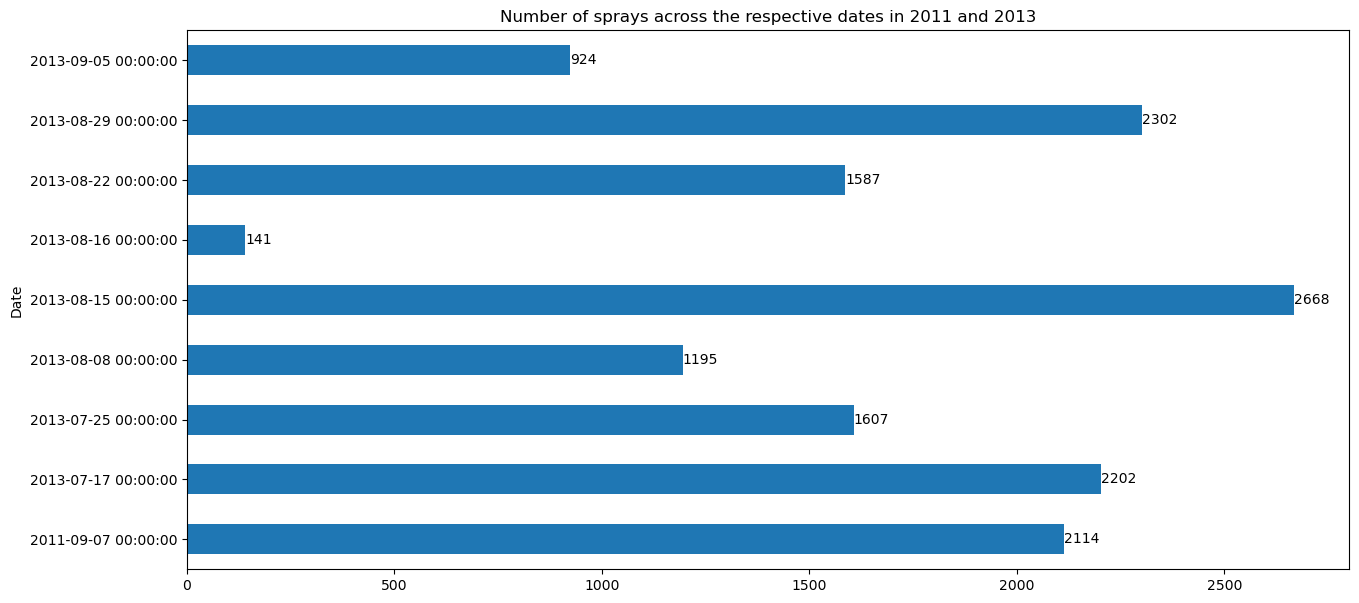

In [11]:
# draw a bar plot counting the number of sprays across the various dates (with count annotation)
sizes = spray.groupby(["Date"]).size()
sizes.plot(kind='barh',figsize=(15,7),title="Number of sprays across the respective dates in 2011 and 2013")

for y, x in enumerate(sizes):
    plt.annotate(str(x), xy=(x, y), va='center')

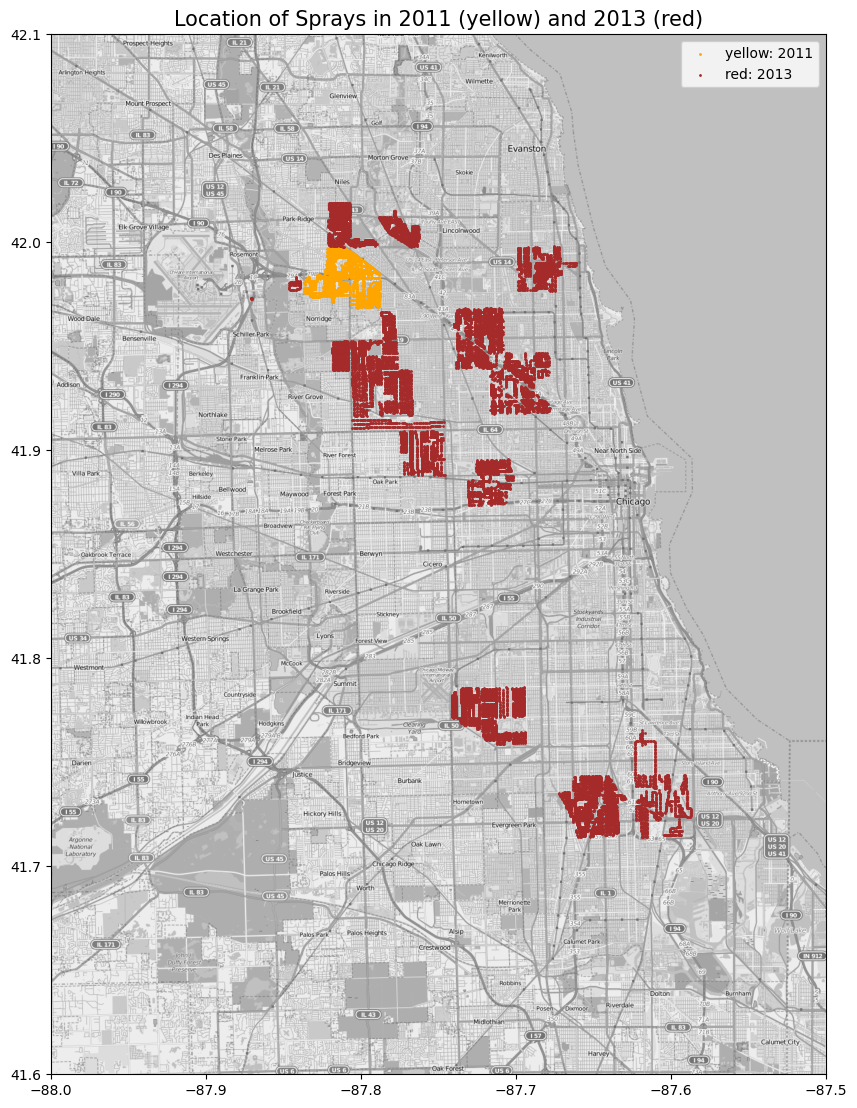

In [12]:
#plot locations of sprays  
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

spray["Year"] = spray["Date"].dt.year
spray_2011 = spray.loc[spray["Year"]==2011]
spray_2013 = spray.loc[spray["Year"]==2013]
spray.drop(["Year"], axis=1, inplace=True)

sp_2011 = plt.scatter(spray_2011['Longitude'], spray_2011['Latitude'], c="orange", marker='o', s=1, alpha=1)
sp_2013 = plt.scatter(spray_2013['Longitude'], spray_2013['Latitude'], c="brown", marker='o', s=1, alpha=1)

plt.title("Location of Sprays in 2011 (yellow) and 2013 (red)", fontsize=15)
plt.legend((sp_2011, sp_2013), ("yellow: 2011", "red: 2013"))
plt.show();

# EDA for Train

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


### Distribution of Data

In [14]:
df_ben = clean_train(train)

In [15]:
df_ben.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
1 2007-05-29          CULEX RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29          CULEX RESTUANS  T007  41.994991 -87.769279   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
4 2007-05-29          CULEX RESTUANS  T015  41.974089 -87.824812   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [16]:
df_ben.describe()

Latitude    Longitude  NumMosquitos   WnvPresent
count  8475.000000  8475.000000   8475.000000  8475.000000
mean     41.844618   -87.694788     15.933805     0.053923
std       0.106609     0.084063     75.084707     0.225880
min      41.644612   -87.930995      1.000000     0.000000
25%      41.750498   -87.752329      2.000000     0.000000
50%      41.857402   -87.694991      4.000000     0.000000
75%      41.944869   -87.642984     11.000000     0.000000
max      42.017430   -87.531635   2532.000000     1.000000

In [17]:
def plot_distribution(train_df):
  fig, ax = plt.subplots(figsize=(10,14), dpi=150)
  plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=(-88, -87.5, 41.6, 42.1))
  sns.scatterplot(ax=ax,data=train_df[train_df['WnvPresent']==False], x= 'Longitude', y='Latitude',color='blue',alpha=0.1)
  sns.scatterplot(ax=ax,data=train_df[train_df['WnvPresent']==True], x= 'Longitude', y='Latitude',color='red',alpha=0.1)

  labels = train_df.groupby(['Trap','WnvPresent']).agg({'Latitude':np.mean, 'Longitude':np.mean}).reset_index()

  for label in labels[labels['WnvPresent']==True].iterrows():
      plt.annotate(text=label[1]['Trap'],xy=(label[1]['Longitude'],label[1]['Latitude']))

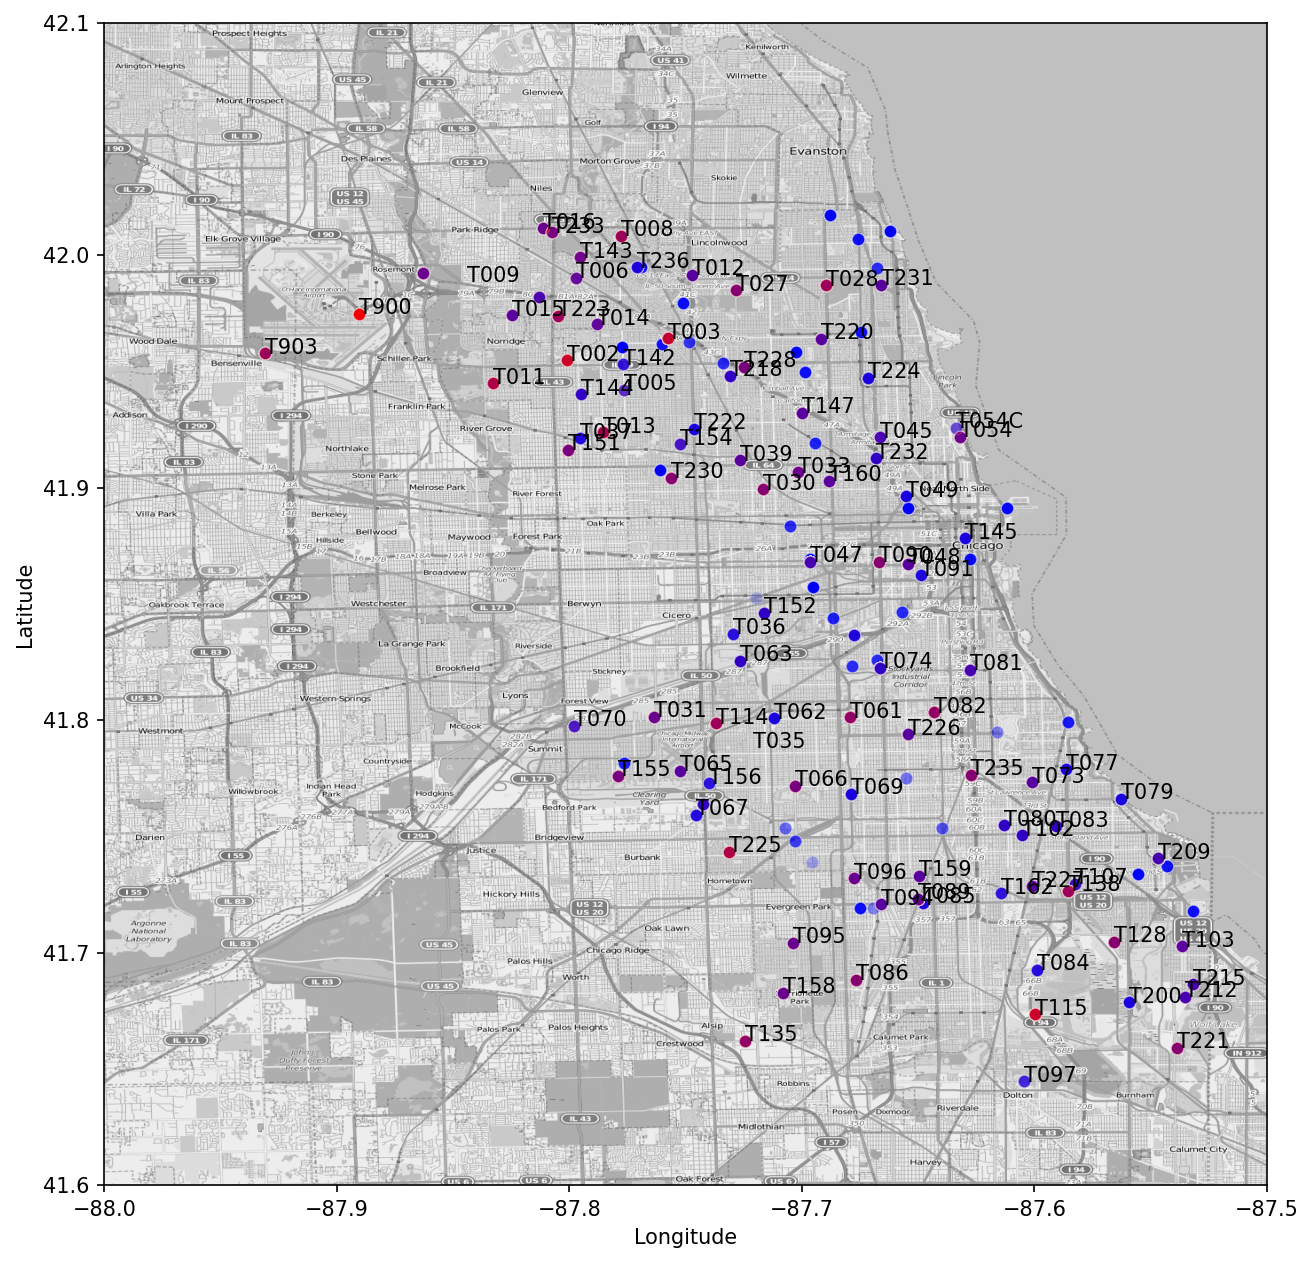

In [18]:
plot_distribution(df_ben)

We can see across 2003 and 2013, WNV has been detected across the traps.

Let's see the distribution of WNV to Traps.

In [19]:
def trap_mossi_dist(train_df):
  count = train_df[train_df['WnvPresent']==True].groupby('Trap').agg({'WnvPresent':'count'})
  count[count['WnvPresent']>5].sort_values(by='WnvPresent').plot(kind='bar')
  plt.ylabel('No. of times WNV present')

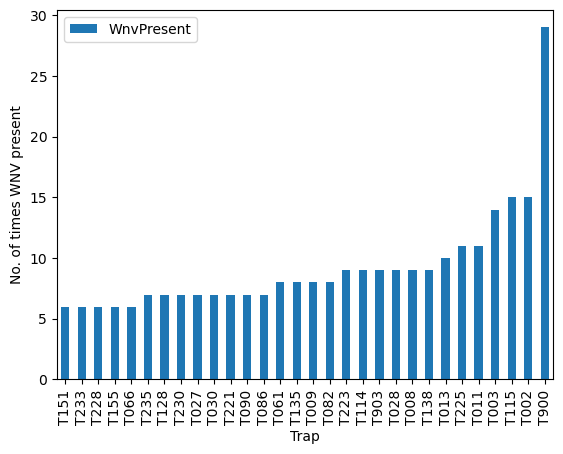

In [20]:
trap_mossi_dist(df_ben)

In [21]:
df_sy = clean_train(train)

In [22]:
df_sy['Date'] = pd.to_datetime(df_sy['Date'])

In [23]:
#create month, week and year columns to help with prelim EDA 
df_sy['Month'] = df_sy['Date'].dt.month
df_sy['Week'] = df_sy['Date'].dt.isocalendar().week
df_sy['Year'] = df_sy['Date'].dt.year
df_sy['Year Month'] = df_sy['Date'].dt.strftime('%Y %m')

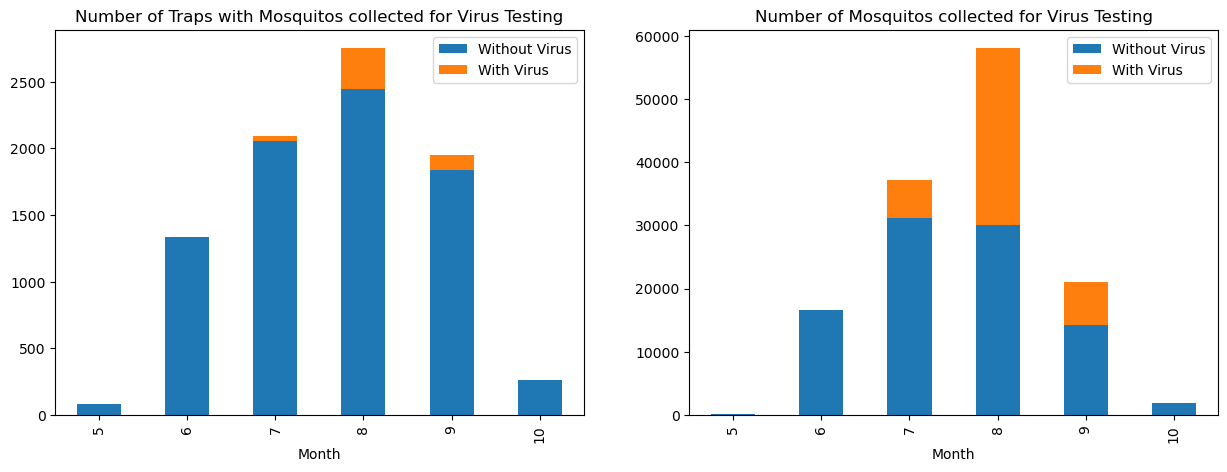

In [24]:
# create pivot to count number of traps collected for virus testing
month_with_virus_count = df_sy.pivot_table(values=['NumMosquitos'], index='Month',
                                       columns='WnvPresent', aggfunc='count')

# create pivot to count number of mosquitos collected for testing 
month_with_virus_sum = df_sy.pivot_table(values=['NumMosquitos'], index='Month',
                                       columns='WnvPresent', aggfunc='sum')

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))

month_with_virus_count.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("Number of Traps with Mosquitos collected for Virus Testing")
axes[0].set_xlabel("Month")
axes[0].legend(labels=["Without Virus", "With Virus"])

month_with_virus_sum.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Number of Mosquitos collected for Virus Testing")
axes[1].set_xlabel("Month")
axes[1].legend(labels=["Without Virus", "With Virus"]); 

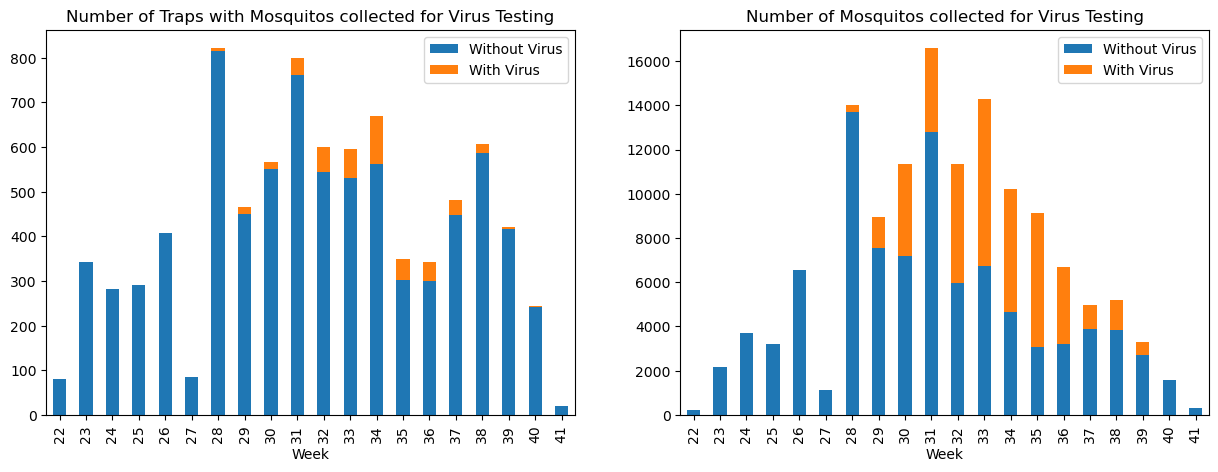

In [25]:
# create pivot to count number of traps collected for virus testing
month_with_virus_count = df_sy.pivot_table(values=['NumMosquitos'], index='Week',
                                       columns='WnvPresent', aggfunc='count')

# create pivot to count number of mosquitos collected for testing 
month_with_virus_sum = df_sy.pivot_table(values=['NumMosquitos'], index='Week',
                                       columns='WnvPresent', aggfunc='sum')

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))

month_with_virus_count.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("Number of Traps with Mosquitos collected for Virus Testing")
axes[0].set_xlabel("Week")
axes[0].legend(labels=["Without Virus", "With Virus"])

month_with_virus_sum.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Number of Mosquitos collected for Virus Testing")
axes[1].set_xlabel("Week")
axes[1].legend(labels=["Without Virus", "With Virus"]); 

## Species and WNV

In [26]:
df_ben[['Species','WnvPresent']].value_counts().sort_index()

Species                 WnvPresent
CULEX ERRATICUS         0                1
CULEX PIPIENS           0             1766
                        1              184
CULEX PIPIENS/RESTUANS  0             3601
                        1              225
CULEX RESTUANS          0             2345
                        1               48
CULEX SALINARIUS        0               83
CULEX TARSALIS          0                6
CULEX TERRITANS         0              216
dtype: int64

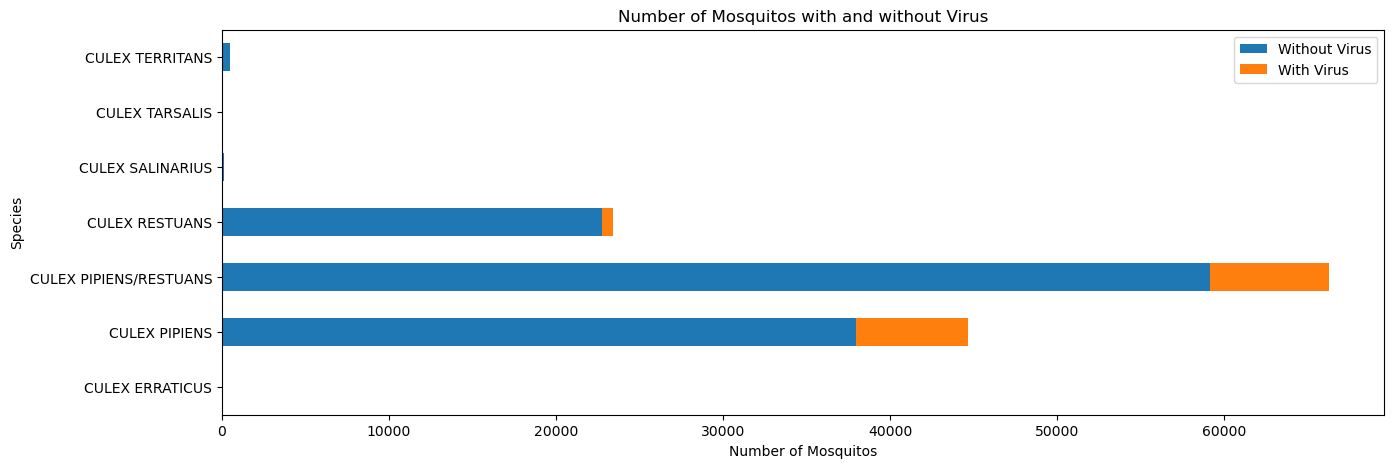

In [27]:
species_with_virus = train.pivot_table(values=['NumMosquitos'], index='Species',
                                       columns='WnvPresent', aggfunc='sum')

species_with_virus.plot(kind='barh', stacked=True, figsize=(15,5))
plt.title("Number of Mosquitos with and without Virus")
plt.xlabel("Number of Mosquitos")
plt.legend(labels=["Without Virus", "With Virus"]);

We can see that only three categories carry the virus.

## Time analysis wrt to mosquito count and WNV presence

In [28]:
def plot_time_mossi(train_df):
  fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,15), sharey=True)


  ax1=sns.scatterplot(ax=axs[0][0],data=train_df[train_df['Date'].dt.year.between(2007,2008)], x='Date', y='NumMosquitos', hue='WnvPresent', alpha=0.5)
  ax2=sns.scatterplot(ax=axs[0][1],data=train_df[train_df['Date'].dt.year.between(2009,2010)], x='Date', y='NumMosquitos', hue='WnvPresent', alpha=0.5)
  ax3=sns.scatterplot(ax=axs[1][0],data=train_df[train_df['Date'].dt.year.between(2011,2012)], x='Date', y='NumMosquitos', hue='WnvPresent', alpha=0.5)
  ax4=sns.scatterplot(ax=axs[1][1],data=train_df[train_df['Date'].dt.year.between(2013,2014)], x='Date', y='NumMosquitos', hue='WnvPresent', alpha=0.5)

  for ax_r in axs:
      for ax_c in ax_r:
          sns.move_legend(ax_c,loc="upper left", bbox_to_anchor=(1, 1))
          for index, tick in enumerate(ax_c.get_xaxis().get_major_ticks()):
              if index%2==1:
                  tick.set_pad(20)

  ax1.set_title('2007')
  ax2.set_title('2009')
  ax3.set_title('2011')
  ax4.set_title('2013')

  fig.suptitle('Number of Mosquitos vs Time', fontsize=20)
  plt.show()

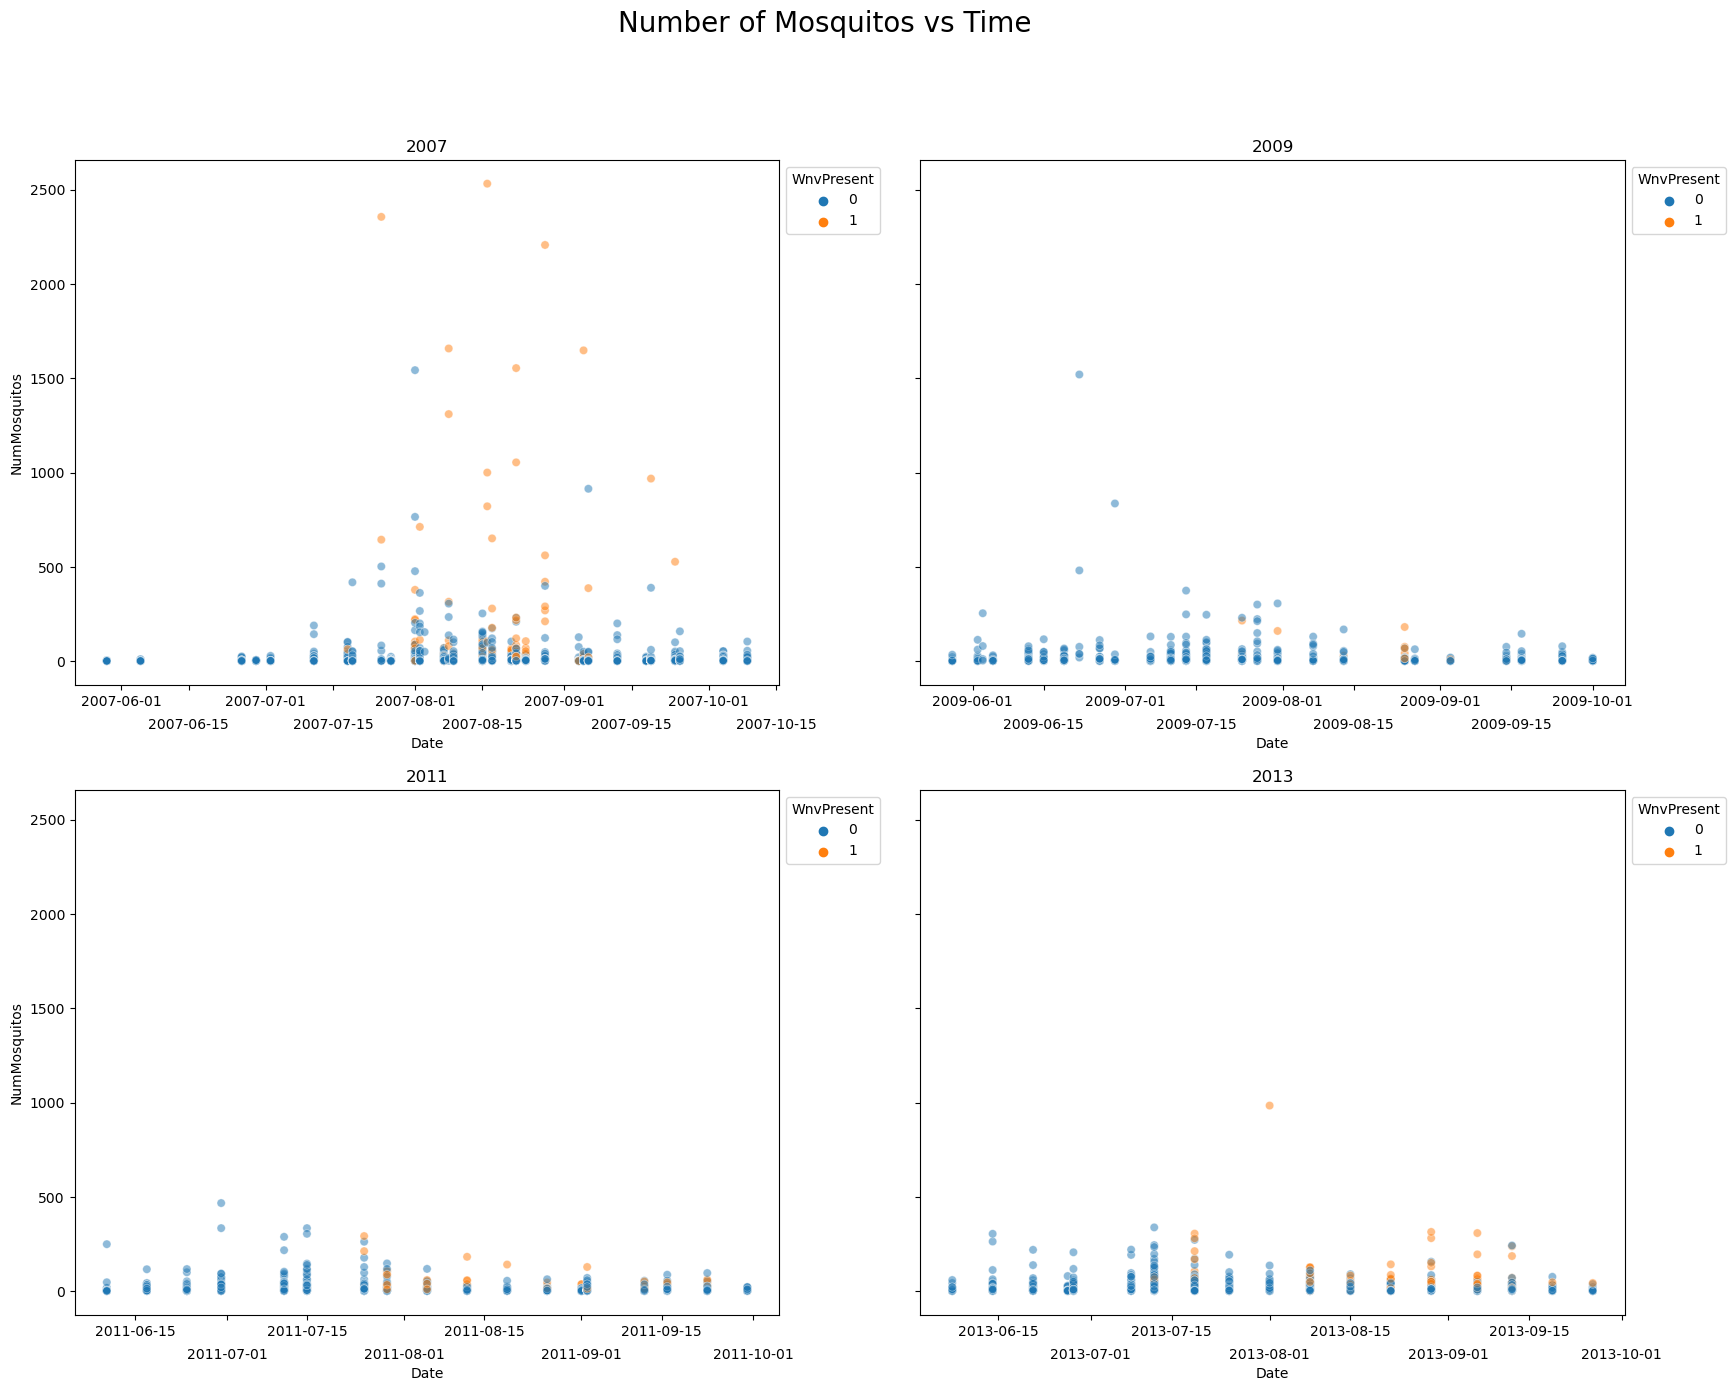

In [29]:
plot_time_mossi(df_ben)

We can see that in 2007 had relatively many mosqitoes compared to the other four years.

However, we can observe that between July and October is when cases of WNV are detected.

In [30]:
def plot_month_mossi(train_df):
  plt.subplots(figsize=(10,7))
  sns.lineplot(x=train_df['Date'].dt.month, y=train_df['WnvPresent'], hue=train_df['Date'].dt.year, palette = 'Spectral')
  plt.ylabel("Likelihood of positive testing for WNV among trapped mosquitos")
  plt.xlabel('Month of the Year')
  plt.title('Chance of detecting WNV vs Month of the year')
  plt.show()

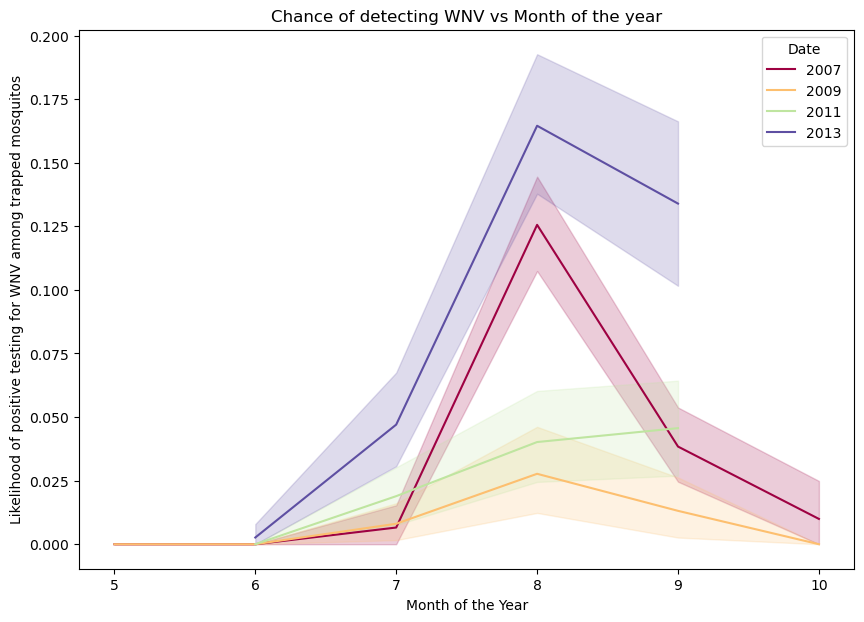

In [31]:
plot_month_mossi(df_ben)

From here we can see that the chance of detecting WNV peaks in August except for 2011.

In [32]:
def plot_yearmonth_mossi(train_df):
  fig, ax = plt.subplots(figsize=(10,5),)
  plot_1 = train_df.groupby(by=[train_df.Date.dt.year, train_df.Date.dt.month]).agg({'NumMosquitos':np.sum}).plot(kind='bar', ax=ax)
  plot_2 = train_df.groupby(by=[train_df.Date.dt.year, train_df.Date.dt.month]).agg({'WnvPresent':np.sum}).plot(kind='line',color='red', ax=ax, secondary_y=True)
  fig.autofmt_xdate(rotation=90)
  plot_2.yaxis.set_tick_params(which='major',color='red', labelcolor='red')
  plot_1.set_ylabel('Number of mosquitos')
  plot_2.set_ylabel('Number of traps of which WNV present')
  ax.set_xlabel('Date (year, month)')
  plt.show()

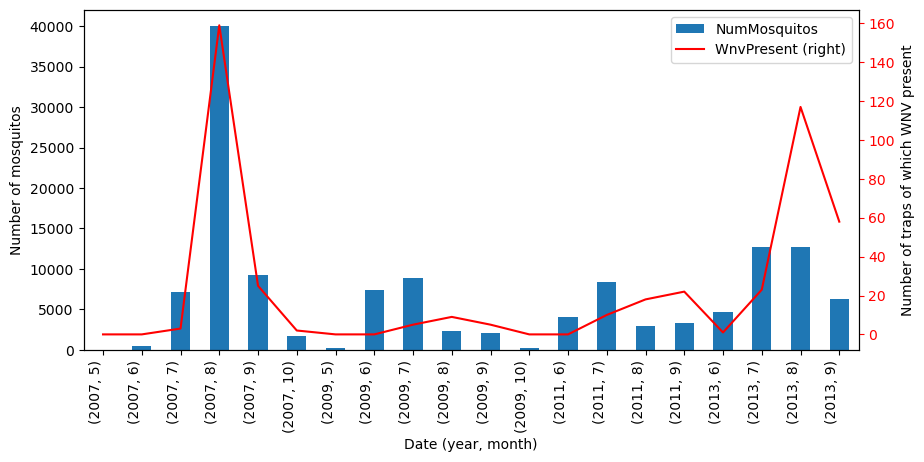

In [33]:
plot_yearmonth_mossi(df_ben)

We can see that only in 2007, the number of mosquitos correlate with the dectection of WNV.

Let's compare it to the national incidence report rate. West Nile virus neuroinvasive disease incidence reported to CDC by year, 1999-2021

<img src='https://drive.google.com/uc?id=12IbUXjrXNMqNcTVA1jqXd0e5DiOmdn1a'>

# EDA for Weather

## Distributions

In [34]:
weather_ben = weather_clean(weather)

In [35]:
weather_ben.head()

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  PrecipTotal  \
0       1 2007-05-01    83    50    67      14        51          0.0   
1       2 2007-05-01    84    52    68      14        51          0.0   
2       1 2007-05-02    59    42    51      -3        42          0.0   
3       2 2007-05-02    60    43    52      -3        42          0.0   
4       1 2007-05-03    66    46    56       2        40          0.0   

   Latitude  Longitude  ...  GR  HZ  MIFG  RA  SN  SQ  TS  TSRA  VCFG  VCTS  
0    41.995    -87.933  ...   0   0     0   0   0   0   0     0     0     0  
1    41.786    -87.752  ...   0   0     0   0   0   0   0     0     0     0  
2    41.995    -87.933  ...   0   0     0   0   0   0   0     0     0     0  
3    41.786    -87.752  ...   0   1     0   0   0   0   0     0     0     0  
4    41.995    -87.933  ...   0   0     0   0   0   0   0     0     0     0  

[5 rows x 26 columns]

In [36]:
weather_ben.describe()

Tmax         Tmin         Tavg       Depart     DewPoint  \
count  2944.000000  2944.000000  2944.000000  2944.000000  2944.000000   
mean     76.166101    57.810462    67.223505     1.954484    53.457880   
std      11.461970    10.381939    10.550252     6.839947    10.675181   
min      41.000000    29.000000    36.000000   -17.000000    22.000000   
25%      69.000000    50.000000    60.000000    -3.000000    46.000000   
50%      78.000000    59.000000    69.000000     2.000000    54.000000   
75%      85.000000    66.000000    75.000000     7.000000    62.000000   
max     104.000000    83.000000    94.000000    23.000000    75.000000   

       PrecipTotal     Latitude    Longitude         BCFG           BR  ...  \
count  2944.000000  2944.000000  2944.000000  2944.000000  2944.000000  ...   
mean      0.144837    41.890500   -87.842500     0.001698     0.276155  ...   
std       0.402128     0.104518     0.090515     0.041183     0.447170  ...   
min       0.000000    41.786000   -87.933000     0.000000     0.000000  ...   
25%       0.000000    41.786000   -87.933000     0.000000     0.000000  ...   
50%       0.000000    41.890500   -87.842500     0.000000     0.000000  ...   
75%       0.090000    41.995000   -87.752000     0.000000     1.000000  ...   
max       6.860000    41.995000   -87.752000     1.000000     1.000000  ...   

               GR           HZ         MIFG           RA           SN  \
count  2944.00000  2944.000000  2944.000000  2944.000000  2944.000000   
mean      0.00034     0.089334     0.001019     0.317595     0.002038   
std       0.01843     0.285274     0.031911     0.465620     0.045106   
min       0.00000     0.000000     0.000000     0.000000     0.000000   
25%       0.00000     0.000000     0.000000     0.000000     0.000000   
50%       0.00000     0.000000     0.000000     0.000000     0.000000   
75%       0.00000     0.000000     0.000000     1.000000     0.000000   
max       1.00000     1.000000     1.000000     1.000000     1.000000   

                SQ           TS         TSRA         VCFG         VCTS  
count  2944.000000  2944.000000  2944.000000  2944.000000  2944.000000  
mean      0.001019     0.034647     0.103601     0.001359     0.006454  
std       0.031911     0.182914     0.304793     0.036842     0.080090  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 24 columns]

In [37]:
def plot_boxes(weather_df):
  features = ['Tmax','Tmin','Tavg','Depart','DewPoint','PrecipTotal']

  for feature in features:
    fig, ax = plt.subplots()
    sns.boxplot(ax=ax, x=weather_df['Date'].dt.month, y=weather_df[feature], color='skyblue');

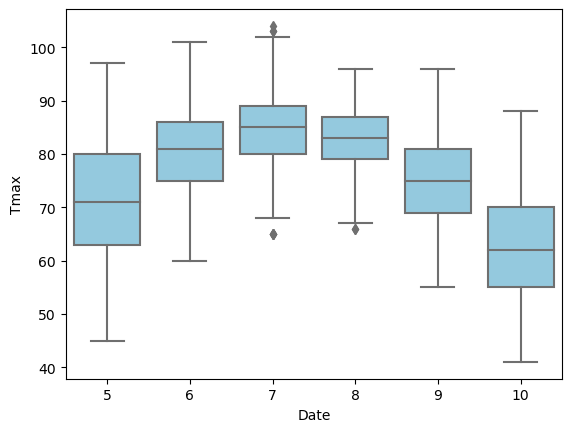

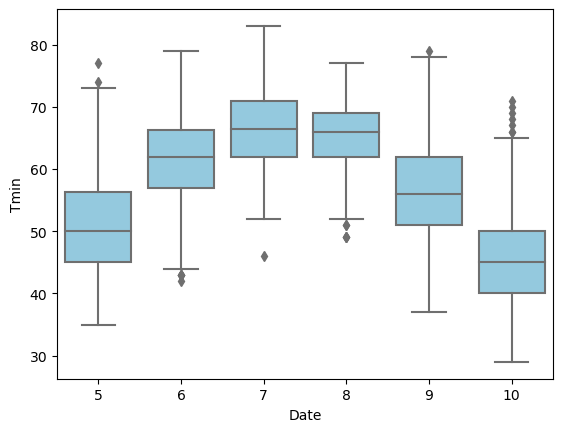

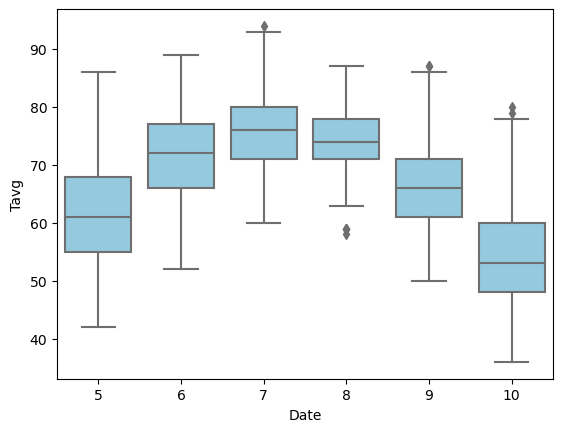

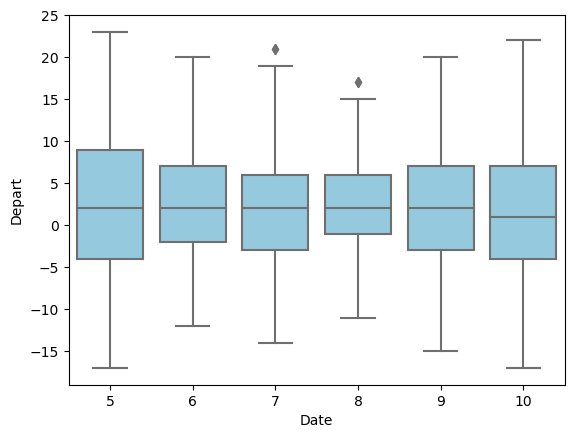

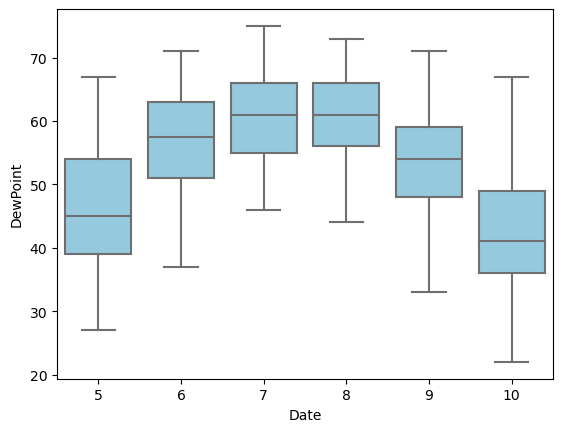

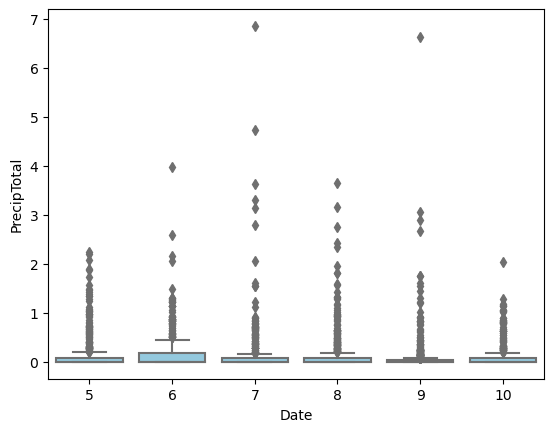

In [38]:
plot_boxes(weather_ben)

We observe that in July and August, the weather is generally higher.

## Merge Train and Weather

In [39]:
## Merge Train and Weather (9 days rolling)

In [40]:
df_ben = df_ben.merge(join_stations(weather_ben).drop(columns=['Latitude','Longitude']), left_on = 'Date', right_on = 'Date')

In [41]:
df_ben.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
1 2007-05-29          CULEX RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29          CULEX RESTUANS  T007  41.994991 -87.769279   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
4 2007-05-29          CULEX RESTUANS  T015  41.974089 -87.824812   

   NumMosquitos  WnvPresent       Tmax       Tmin       Tavg  ...  GR2  \
0             1           0  80.111111  54.888889  67.666667  ...  0.0   
1             1           0  80.111111  54.888889  67.666667  ...  0.0   
2             1           0  80.111111  54.888889  67.666667  ...  0.0   
3             1           0  80.111111  54.888889  67.666667  ...  0.0   
4             4           0  80.111111  54.888889  67.666667  ...  0.0   

        HZ2  MIFG2       RA2  SN2  SQ2  TS2     TSRA2  VCFG2  VCTS2  
0  0.222222    0.0  0.444444  0.0  0.0  0.0  0.111111    0.0    0.0  
1  0.222222    0.0  0.444444  0.0  0.0  0.0  0.111111    0.0    0.0  
2  0.222222    0.0  0.444444  0.0  0.0  0.0  0.111111    0.0    0.0  
3  0.222222    0.0  0.444444  0.0  0.0  0.0  0.111111    0.0    0.0  
4  0.222222    0.0  0.444444  0.0  0.0  0.0  0.111111    0.0    0.0  

[5 rows x 53 columns]

In [42]:
df_ben.corr(numeric_only=True)['WnvPresent'].sort_values(ascending=False)

WnvPresent      1.000000
NumMosquitos    0.233532
DewPoint        0.124129
DewPoint2       0.109199
Tmin            0.099406
Tmin2           0.093532
TS2             0.092839
TS              0.088532
Tavg            0.083581
Tavg2           0.081438
FG2             0.069276
TSRA            0.069051
PrecipTotal2    0.067566
Tmax            0.064851
Tmax2           0.062960
TSRA2           0.049461
Depart2         0.043642
Depart          0.043642
RA              0.036832
Latitude        0.030862
BR2             0.020816
RA2             0.020071
PrecipTotal     0.019212
BR              0.016027
VCTS2           0.008491
DZ2            -0.005236
GR2            -0.012960
FG             -0.017357
BCFG2          -0.020625
BCFG           -0.023002
SQ             -0.023452
VCTS           -0.023508
HZ2            -0.023598
VCFG2          -0.024808
MIFG           -0.036841
FU2            -0.037167
DZ             -0.037956
FG+2           -0.039613
FU             -0.044390
FG+            -0.047516


In [43]:
def plot_mossi_feature(merged_df,feature):
  YEARS = [2007,2009,2011,2013]

  for YEAR in YEARS:
      fig, axes = plt.subplots(figsize=(15,5),dpi=100)

      num_mossies = sns.scatterplot(data=merged_df[merged_df['Date'].dt.year==YEAR], x='Date', y='NumMosquitos',hue='WnvPresent', alpha = 0.5)
      temp = num_mossies.twinx()
      temperture = sns.lineplot(ax=temp,data=merged_df[merged_df['Date'].dt.year==YEAR], x='Date', y=feature,color='red',label=feature)
      temp.legend()

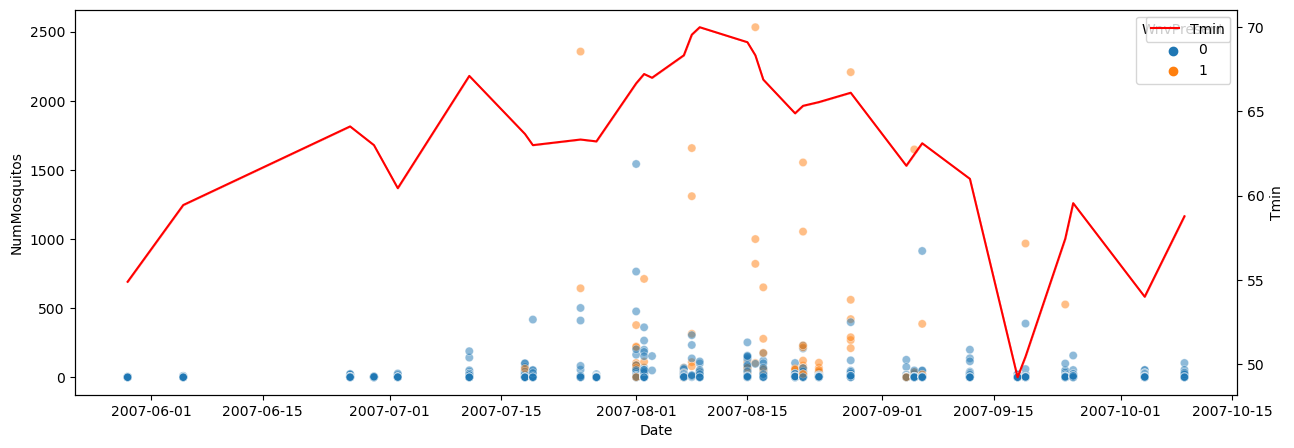

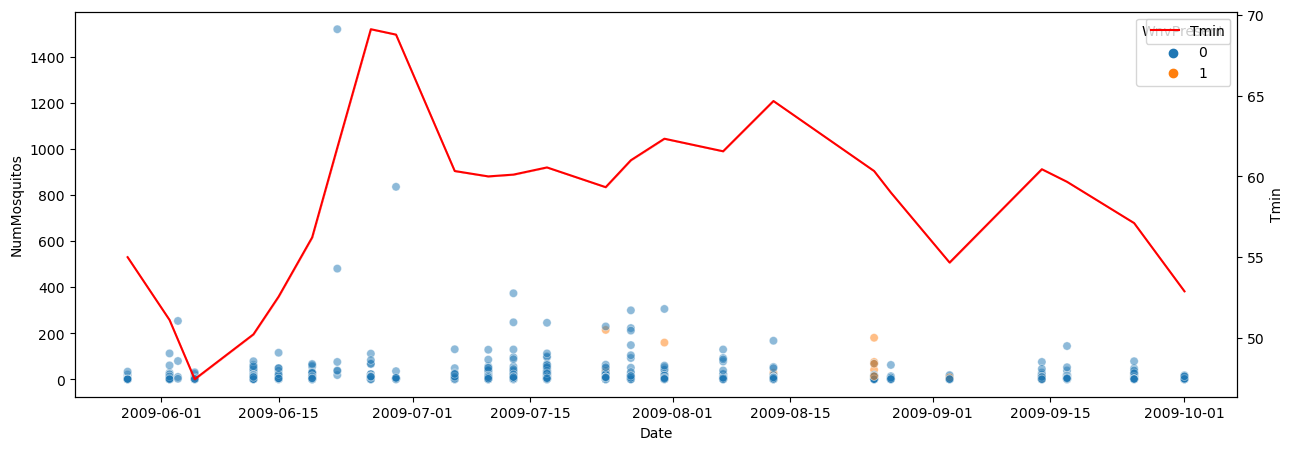

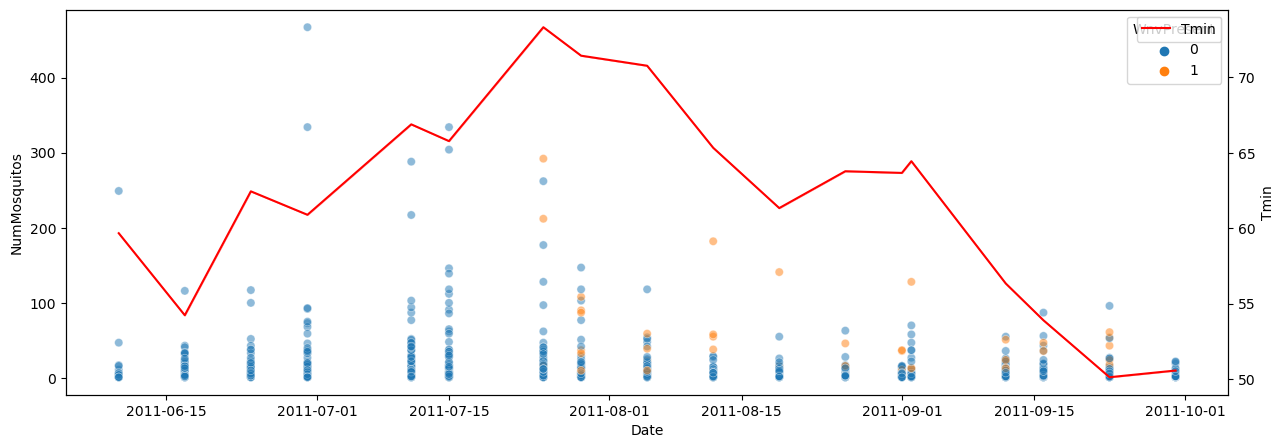

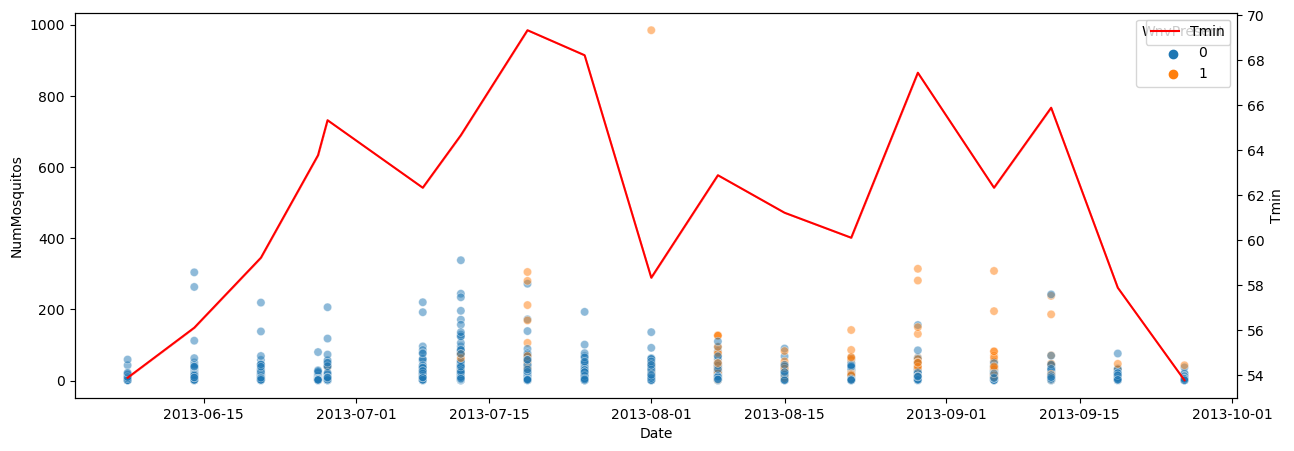

In [44]:
plot_mossi_feature(df_ben,'Tmin')

In [45]:
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

# create function to assign observation based on latitude and longitude to either stations
def assign_station(lat:int, lng:int):
    coord_stn1 = (41.995, -87.933)
    coord_stn2 = (41.786, -87.752)
    coord_curr = (lat, lng)
    return 1 if geodesic(coord_curr, coord_stn1) < geodesic(coord_curr, coord_stn2) else 2

In [46]:
# apply the function to create the assignment of observation to weather stations 
df_sy['Station'] = df_sy.apply(lambda x: assign_station(x['Latitude'], x['Longitude']), axis=1)

In [47]:
# save weather's Data as pd's datetime format to ensure consistency in data format across different dataframes 
weather['Date'] = pd.to_datetime(weather['Date'])

In [48]:
# merge data 
df_sy_merged = df_sy.merge(weather, how="left", on=["Station", "Date"])
df_sy_merged.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
1 2007-05-29          CULEX RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29          CULEX RESTUANS  T007  41.994991 -87.769279   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
4 2007-05-29          CULEX RESTUANS  T015  41.974089 -87.824812   

   NumMosquitos  WnvPresent  Month  Week  Year  ... CodeSum  Depth  Water1  \
0             1           0      5    22  2007  ...   BR HZ    0.0     NaN   
1             1           0      5    22  2007  ...   BR HZ    0.0     NaN   
2             1           0      5    22  2007  ...   BR HZ    0.0     NaN   
3             1           0      5    22  2007  ...   BR HZ    0.0     NaN   
4             4           0      5    22  2007  ...   BR HZ    0.0     NaN   

   SnowFall  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  \
0       0.0          0.0        29.39     30.11          5.8         18   
1       0.0          0.0        29.39     30.11          5.8         18   
2       0.0          0.0        29.39     30.11          5.8         18   
3       0.0          0.0        29.39     30.11          5.8         18   
4       0.0          0.0        29.39     30.11          5.8         18   

   AvgSpeed  
0       6.5  
1       6.5  
2       6.5  
3       6.5  
4       6.5  

[5 rows x 32 columns]

In [49]:
def target_plot(target, color, spray_df):
    spray1 = spray_df.assign(
    Year = spray['Date'].dt.year,
    Week = spray['Date'].dt.isocalendar().week)
    for year in [2011, 2013]:
        fig, ax1 = plt.subplots(figsize=(10,4))
        temp_df = df_sy_merged[df_sy_merged['Year']==year].groupby(['Week'])[target].sum().to_frame()
        sns.lineplot(x=temp_df.index, y=temp_df[target],
                     color=color, label=f'{target}', ax=ax1)
        ax1.set_ylabel(f'{target}', fontsize=13)
        ax1.legend(loc=1)
        
        if year in spray1['Year'].unique():
            for date in spray1[spray1['Year'] == year].groupby('Week').mean().index:
                plt.axvline(date, linestyle='--', color='black', alpha=0.5, label='Spray')
        
        plt.legend([f'{target}', 'Spray'])
        plt.title(f'{target} in {year}')
        plt.tight_layout()

C:\Users\hammi\AppData\Local\Temp\ipykernel_22428\2846091698.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  for date in spray1[spray1['Year'] == year].groupby('Week').mean().index:
C:\Users\hammi\AppData\Local\Temp\ipykernel_22428\2846091698.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  for date in spray1[spray1['Year'] == year].groupby('Week').mean().index:


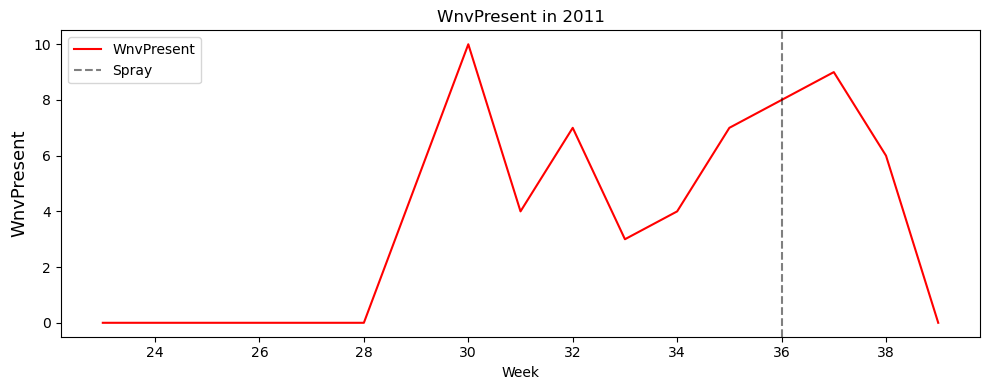

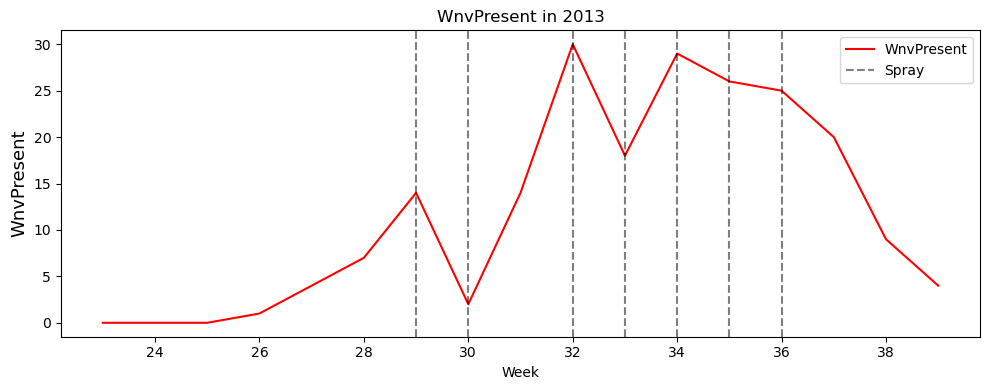

In [50]:
target_plot('WnvPresent', 'red',spray)

C:\Users\hammi\AppData\Local\Temp\ipykernel_22428\2846091698.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  for date in spray1[spray1['Year'] == year].groupby('Week').mean().index:
C:\Users\hammi\AppData\Local\Temp\ipykernel_22428\2846091698.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  for date in spray1[spray1['Year'] == year].groupby('Week').mean().index:


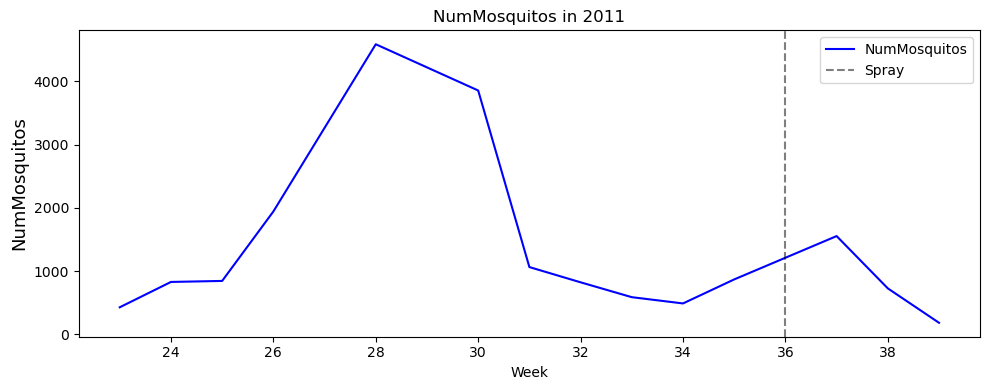

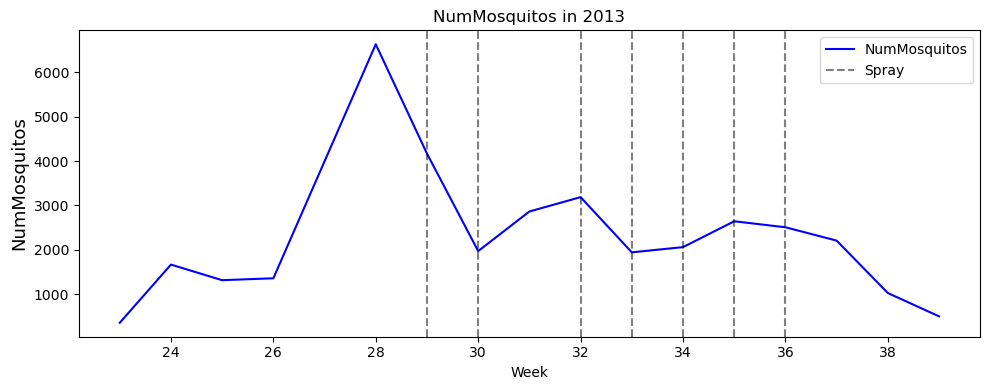

In [51]:
target_plot('NumMosquitos', 'blue', spray)

## Corr between wnv_present and num_mosquitos = 0.52

In [52]:
train_la = clean_train(train)
case_by_date_la = train_la.groupby(by=['Date']).agg({'Latitude':np.mean,'Longitude':np.mean,'NumMosquitos':np.sum,'WnvPresent':np.max}).reset_index()

spray_by_date_la = spray.groupby("Date").count().reset_index().iloc[:,[0,2]].rename(columns={"Latitude":"spray_number"})

train_spray_la = pd.merge(right = case_by_date_la[["Date", "NumMosquitos"]], left=spray_by_date_la, on="Date", how="outer")
train_spray_la = train_spray_la.fillna(0).sort_values(by="Date")

#corr between wnv_present and num_mosquitos is almost 0.6,considered strongly correlated
train_spray_la_2 =pd.concat([clean_train(train), spray_by_date_la]).groupby('Date').agg({'spray_number':'sum', 'NumMosquitos':'sum', 'WnvPresent':'sum'}).reset_index().set_index("Date")

train_spray_la_2.corr()[["WnvPresent"]].drop(['WnvPresent', 'spray_number'])

WnvPresent
NumMosquitos    0.520963

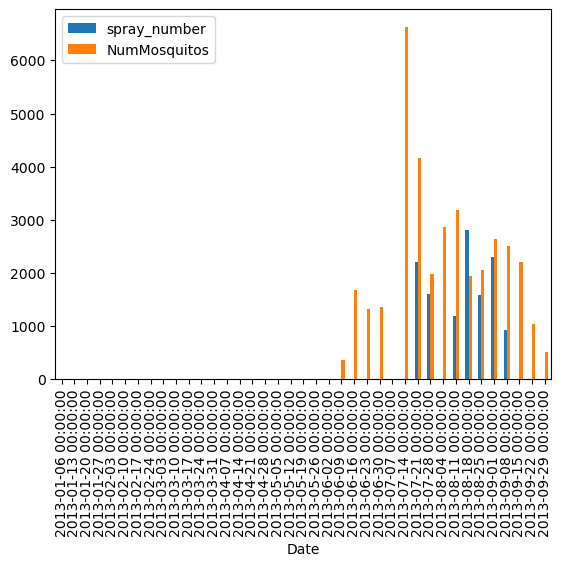

In [53]:
train_spray_la_weekly = train_spray_la_2.resample('W').sum()

#action of spray was more active in 2013, total 8 days
#while in 2011 was only 2 days, shown in zoom-out graph below
fig, ax = plt.subplots()
train_spray_la_weekly[train_spray_la_weekly.index > "2013"].plot(
    kind="bar",y=["spray_number", "NumMosquitos"], ax=ax)
plt.show();

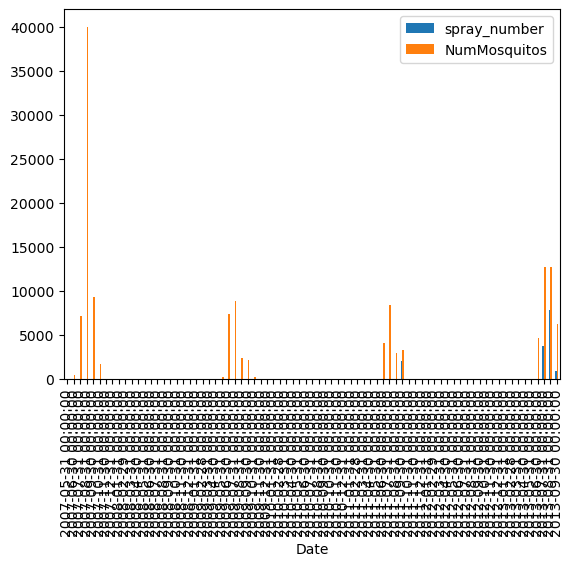

In [54]:
train_spray_la_monthly = train_spray_la_2.resample('M').sum()

#graph showing effectiveness of spray number on reducing number of mosquitoes, comparing 2007 and 2013
fig, ax = plt.subplots()
train_spray_la_monthly.plot(kind="bar",y=["spray_number", "NumMosquitos"], ax=ax)
plt.show();

With human intervention, number of mosquitoes reduced steadily in 2013. If not, the number of mosquitoes will be out of control, which surged to almost 40k in Aug 2007. The higher the number of mosquitoes, the higher the wnv cases detected.  The reason number of mosquitos is taken as proxy of wnv cases is because of the relatively low scale presented as compared to spray number. This relationship between number of mosquitoes and wnv cases will be shown below.

In [55]:
train_la.columns

train = train.assign(pipiens_present = lambda x: x["Species"].str.contains("CULEX PIPIENS").astype(int))
train = train.assign(restuans_present = lambda x: x["Species"].str.contains("RESTUANS").astype(int))

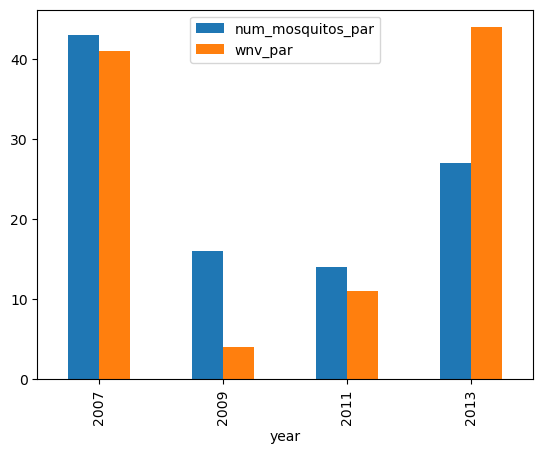

In [56]:
train_la["year"] = train_la["Date"].dt.year

#group by year
normalised_year = train_la.groupby("year")[["NumMosquitos", "WnvPresent"]].sum().reset_index()

#normalise the feature to convert them into percentage for easier comparison
normalised_year["num_mosquitos_par"] = normalised_year["NumMosquitos"].apply(
    lambda x: np.round(x/normalised_year["NumMosquitos"].sum()*100),4)

normalised_year["wnv_par"] = normalised_year["WnvPresent"].apply(
    lambda x: np.round(x/normalised_year["WnvPresent"].sum()*100),4)

normalised_year.plot(kind="bar", x="year", y=["num_mosquitos_par", "wnv_par"]);

The graph presented is based on normalized data to show the proportion in different years and the diff beween number of mosquitos and present of wnv cases. The graph shows that 2013 has much higher cases found relative to the number of mosquitos and 2009 has much lower wnv cases.

## BY MONTH: Number of Mosquitoes vs Presence of WNV

In [57]:
train_la.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'year'],
      dtype='object')

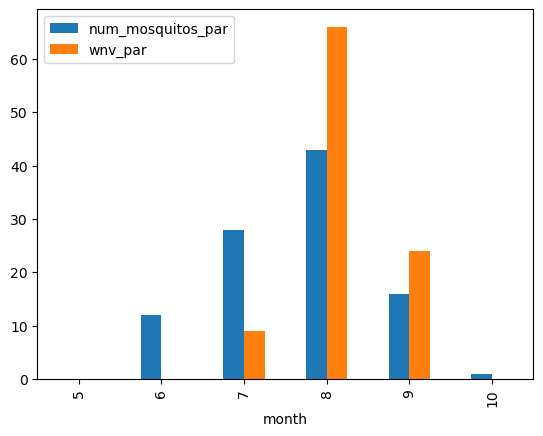

In [58]:
train_la["month"] = train_la["Date"].dt.month

#group by month
normalised_month = train_la.groupby("month")[["NumMosquitos", "WnvPresent"]].sum().reset_index()

#normalise the feature to convert them into percentage for easier comparison
normalised_month["num_mosquitos_par"] = normalised_month["NumMosquitos"].apply(
    lambda x: np.round(x/normalised_month["NumMosquitos"].sum()*100),4)

normalised_month["wnv_par"] = normalised_month["WnvPresent"].apply(
    lambda x: np.round(x/normalised_month["WnvPresent"].sum()*100),4)

normalised_month.plot(kind="bar", x="month", y=["num_mosquitos_par", "wnv_par"]);

Aug is observed to have highest cases of WNV. However, given the higher the number of mosquitos, the higher the wnv cases, July is shown to have much lower wnv cases and Aug has much higher cases. It could be because of the lag effect from breeding of mosquitos to transmission of virus on hosts. [A study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6164257/) suggested that the peak in WNV cases lagged behind the peak in mosquito numbers by several weeks or more. Mosquito abundance usually peaked in late July while the numbers of human disease cases peaked in August and September.

# Tavg

In [59]:
def weather_clean_la(df_weather):
    return (df_weather
     [['Station','Date','Tavg', 'DewPoint','CodeSum','PrecipTotal']]
     .assign(Date=pd.to_datetime(df_weather['Date']),
         Tavg=df_weather['Tavg'].map(lambda x: np.nan if x=='M' else x).ffill(),
         Depart=df_weather['Depart'].map(lambda x: np.nan if x=='M' else x).ffill(),
         PrecipTotal=df_weather['PrecipTotal'].map(lambda x: 0 if x=='  T' else x).map(lambda x: np.nan if x=='M' else x).ffill())
     .astype({'Station':'category','Tavg':'int8','PrecipTotal':'float32', 'DewPoint':'int8'}))

In [60]:
weather_la = weather_clean_la(weather)
weather_la = weather_la[weather_la["Station"]==1].drop(columns='Station', axis=1)

In [61]:
train_la = train_la.assign(pipiens_present = lambda x: x["Species"].str.contains("CULEX PIPIENS").astype(int))
train_la = train_la.assign(restuans_present = lambda x: x["Species"].str.contains("RESTUANS").astype(int))

In [62]:
weather_la.columns

Index(['Date', 'Tavg', 'DewPoint', 'CodeSum', 'PrecipTotal', 'Depart'], dtype='object')

C:\Users\hammi\AppData\Local\Temp\ipykernel_22428\3797551982.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_weather_2 = train_weather.groupby(['year','month']).mean().reset_index()


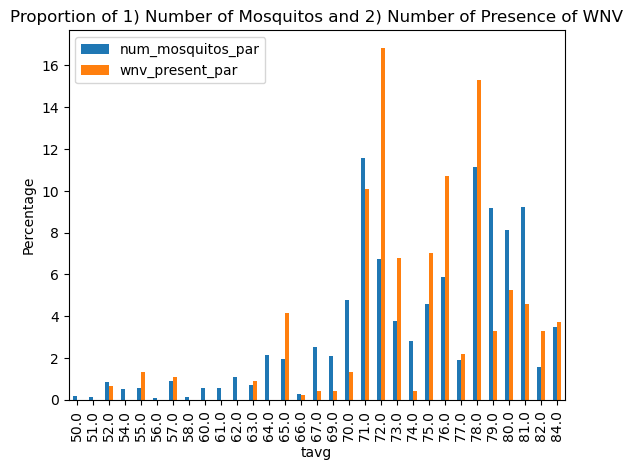

In [63]:
train_weather = train_la.merge(weather_la, on="Date")
train_weather["year"] = train_weather["Date"].dt.year
train_weather["month"] = train_weather["Date"].dt.month
train_weather_2 = train_weather.groupby(['year','month']).mean().reset_index()
train_weather_3 = train_weather.groupby("Date").agg({'NumMosquitos':"sum", 'WnvPresent':"sum",
                                   'pipiens_present': "sum", 'restuans_present': "sum", 'Tavg':"mean",
                                   'DewPoint':"mean", 'PrecipTotal':"mean"})

train_weather.rename(columns=lambda x: re.sub(r'(?<!^)(?=[A-Z])', "_", x).lower(), inplace=True) 
train_weather_2.rename(columns=lambda x: re.sub(r'(?<!^)(?=[A-Z])', "_", x).lower(), inplace=True) 
train_weather_3.rename(columns=lambda x: re.sub(r'(?<!^)(?=[A-Z])', "_", x).lower(), inplace=True) 

tavg_df = train_weather_3.groupby("tavg")[["num_mosquitos", "wnv_present"]].sum().reset_index()
tavg_df["num_mosquitos_par"] = tavg_df["num_mosquitos"].map(lambda x: x/sum(tavg_df["num_mosquitos"])*100)
tavg_df["wnv_present_par"] = tavg_df["wnv_present"].map(lambda x: x/sum(tavg_df["wnv_present"])*100)

tavg_df.plot(kind="bar", x='tavg', y = ["num_mosquitos_par", "wnv_present_par"])
plt.title("Proportion of 1) Number of Mosquitos and 2) Number of Presence of WNV")
plt.ylabel("Percentage");

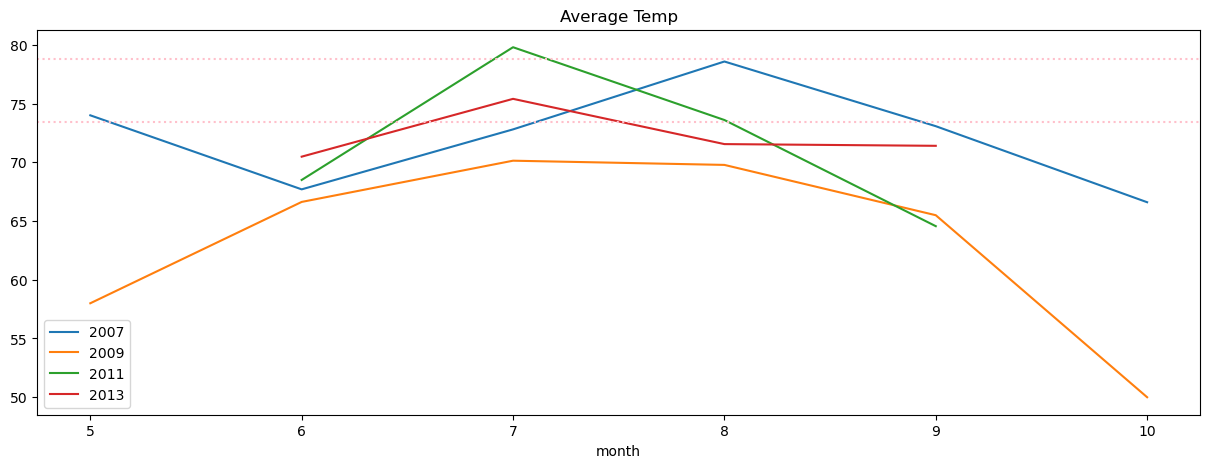

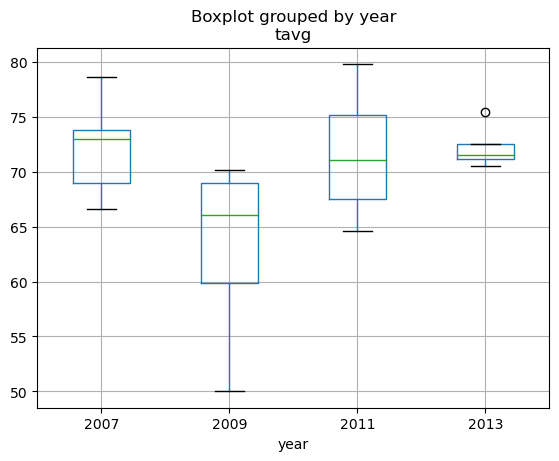

In [64]:

fig, ax = plt.subplots(figsize=(15,5))
for year in train_weather_2["year"].unique():
    train_weather_2[train_weather_2["year"]==year].plot(kind="line", y='tavg', x='month',ax=ax, label=year)
    ax.set_title('Average Temp')
plt.axhline(y=78.8, linestyle=':',color='pink')
plt.axhline(y=73.4, linestyle=':',color='pink');
    
train_weather_2.boxplot("tavg", by="year");

[The article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7492091/#:~:text=Transmission%20of%20West%20Nile%20and,and%2026%C2%B0C%20%2D%20PMC) suggests that transmission of West Nile viruses peaks at temperatures between 23°C and 26°C. This is equivalent to 73.4F and 78.8F. Warmer temperatures associated with climate change can accelerate mosquito development, biting rates, and the incubation of the disease within a mosquito. The average temp graph probably is the reason 2009 has lowest wnv cases.

It is expected that with the optimal temp, the reported cases will be very high, and this is true for year 2007 and 2013, which accounted for 43% and 44% respectively. 

However, 2011 has only 10% of cases reported. Recall the month with highest wnv cases reported, which is Aug, followed by Sep and July. In 2011 Aug and Sep, the temp dropped below the optimal range. Also, July 2011 average temp is above 79F. This could be why 2011 has lesser cases reported. Of course, it is believed that there are other reasons causing this significant drop of cases reported.

Note: Our observation from previous graph is slightly differ in that 72F and 78F are the peak of transmission of WNV. The slight difference could be due to the limited data available that causes some skew of data distribution.

# Precipitation

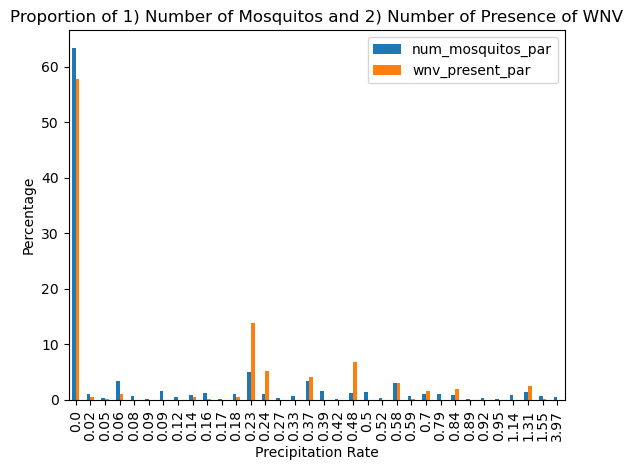

In [65]:
precip_df = train_weather_3.groupby("precip_total")[["num_mosquitos", "wnv_present"]].sum().reset_index()
precip_df["precip_total"] = precip_df["precip_total"].round(2)

precip_df["num_mosquitos_par"] = precip_df["num_mosquitos"].map(lambda x: x/sum(precip_df["num_mosquitos"])*100)
precip_df["wnv_present_par"] = precip_df["wnv_present"].map(lambda x: x/sum(precip_df["wnv_present"])*100)

precip_df.plot(kind="bar", x='precip_total', y = ["num_mosquitos_par", "wnv_present_par"])
plt.title("Proportion of 1) Number of Mosquitos and 2) Number of Presence of WNV")
plt.ylabel("Percentage")
plt.xlabel("Precipitation Rate");

Lower precipitation rate obviously associated with higher number of mosquitos and higher number of presence of WNV.

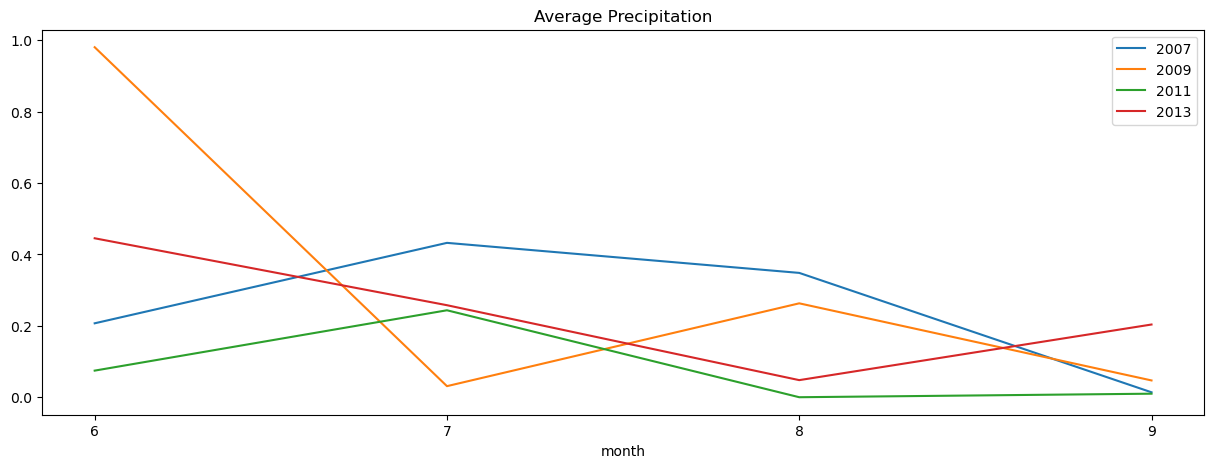

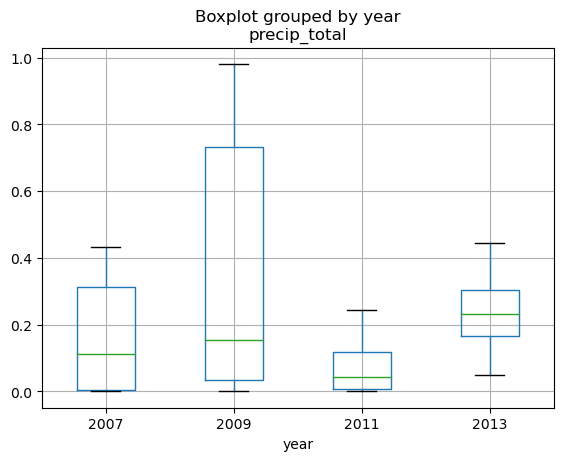

In [66]:
fig, ax = plt.subplots(figsize=(15,5))
for year in train_weather_2["year"].unique():
    train_weather_2[(train_weather_2["year"]==year) &
                    (train_weather_2["month"].between(6,9))].plot(kind="line",
                                                                  y='precip_total',
                                                                  x='month',
                                                                  ax=ax,
                                                                  label=year)
    ax.set_title('Average Precipitation')
    ax.set_xticks(np.arange(6,10,1));
    
train_weather_2.boxplot("precip_total", by="year");

Precipitation indicates the presence of moisture in the atmosphere that has condensed and fallen to the earth's surface in the form of rain, snow, sleet, or hail. Precipitation is an important factor in the water cycle and plays a critical role in the distribution and availability of fresh water on earth. It replenishes water resources such as rivers, lakes, and groundwater, which are essential for agriculture, industry, and human consumption. 

[An article](https://www.epa.gov/climate-indicators/climate-change-indicators-heavy-precipitation#:~:text=The%20potential%20impacts%20of%20heavy,flooding%2Drelated%20effects%20on%20health.) mentioned that increase in flood risk due to heavy rains is one of the potential impacts of heavy precipitation. According to [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4939899/), heavy rains and floodwaters has higher chance to flush out stagnant water sources where mosquitoes reproduce. Whereas lack of precipitation will result in serious water shortage and hence drought. The dry weather facilitates WNV transmission as it forces birds and mosquitoes to share the same scarce sources of water and increases the bird-mosquitoes interaction.

Therefore, it is believed that lower precipitation rate is associated with dry weather and higher transmission of WNV, whereas higher precipitation rate is associated with higher flood risk and lower transmission of WNV. This is consistent with our observation in this dataset (previous graph) that lower precipitation rate causes higher transmission of WNV.

July, Aug and Sept apparently have low precipitation rate, and is undoubtly positively associated with presence of WNV cases.

However, the impact of precipitation rate on the presence of WNV cases is unclear from year to year. While 2007 and 2013 has more severe outbreak of WNV virus, their precipitations rate are not similarily low. Whereas the low precipitaion rate that is favourable to higher transmission of WNV in 2011 turned out to have lower WNV cases.

In 2009, the large variation of precipitation rate is likely due to high precipitation rate in June 2009, which could potentially flush out the water sources and reduced the number of mosquitos in this particular year. There is [another study](https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0006935#:~:text=Excessive%20rainfall%20can%20cause%20breeding,settings%20%5B33%E2%80%9336%5D.) in different context demonstrated the reduction in dengue outbreak risk one to six weeks after flushing events occurred.

# Dew Point

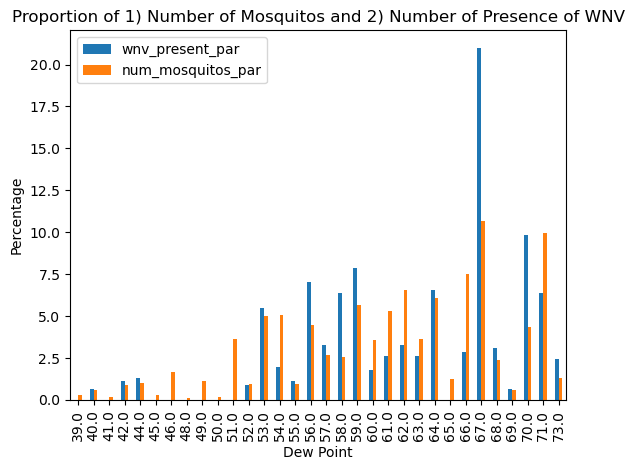

In [67]:
dew_point_df = train_weather_3.groupby("dew_point")[["num_mosquitos", "wnv_present"]].sum().reset_index()
dew_point_df["num_mosquitos_par"] = dew_point_df["num_mosquitos"].map(lambda x: x/sum(dew_point_df["num_mosquitos"])*100)
dew_point_df["wnv_present_par"] = dew_point_df["wnv_present"].map(lambda x: x/sum(dew_point_df["wnv_present"])*100)

dew_point_df.plot(kind="bar", x='dew_point', y = ["wnv_present_par","num_mosquitos_par"])
plt.title("Proportion of 1) Number of Mosquitos and 2) Number of Presence of WNV")
plt.ylabel("Percentage")
plt.xlabel("Dew Point");

The graph shows that the higher the dew point, the higher the number of mosquitos and the higher the number of presence of WNV.

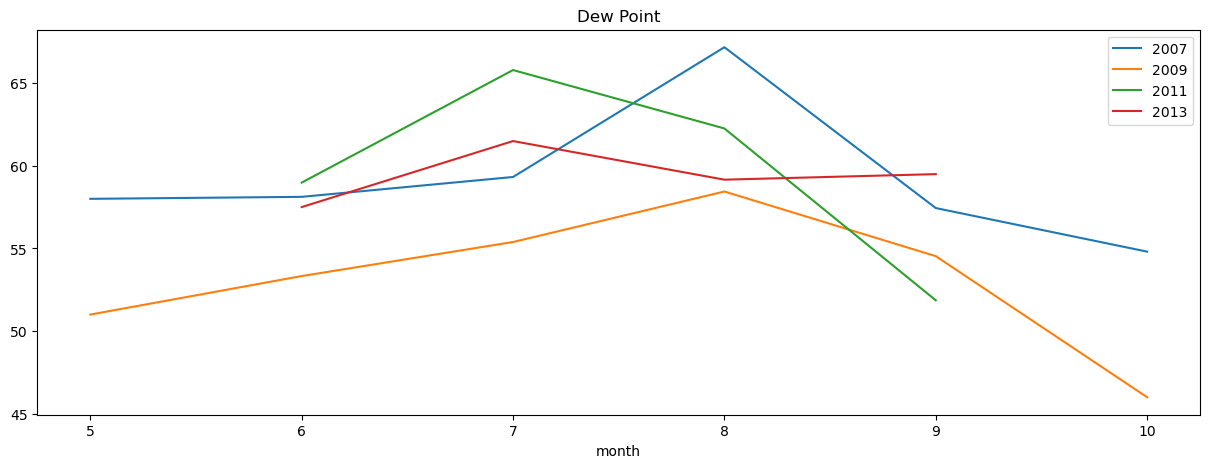

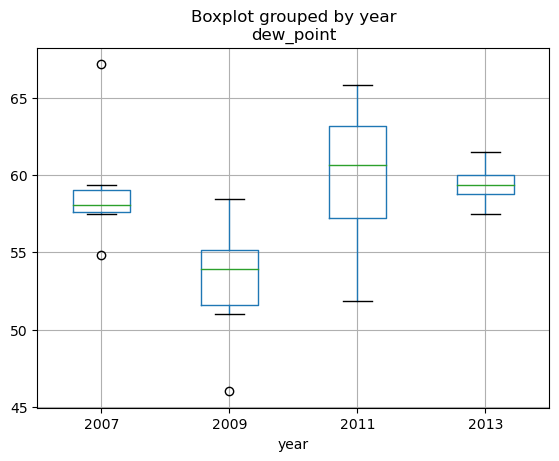

In [68]:
fig, ax = plt.subplots(figsize=(15,5))
for year in train_weather_2["year"].unique():
    train_weather_2[(train_weather_2["year"]==year)].plot(kind="line",
                                                                  y='dew_point',
                                                                  x='month',
                                                                  ax=ax,
                                                                  label=year)
    ax.set_title('Dew Point');
    
train_weather_2.boxplot("dew_point", by="year");

Relative humidity increases as the air temperature drops to the dew point or the dew point rises to the air temperature (since the humidity is relative to the air temperature). In other words, the lower the dew point temperature, the drier the air. The higher the dew point temperature, the more humid the air.


Many Culex mosquitoes initiate host-seeking, blood-feeding, and egg-laying in response to increases in near-surface humidity, so humidity is important for the mosquito life-cycle.  [Refer this.](https://parasitesandvectors.biomedcentral.com/articles/10.1186/s13071-018-2781-0) Hence, the higher dew point and the higher the humidity, the number of WNV cases should be higher. This is consistent with our observation in the graph above, where 67F has the highest number of mosquitos found and positively associated with presence of WNV.

2009 has much lower dew point comparing to other months, it is no suprise that with the out of optimal range of temprature and the lower dew point, it has the lowest recorded WNV cases.

2007 and 2013 that have highest WNV cases has a higher dew point also which facilitates the virus transmission. Nevertheless, 2011 that has lower cases reported is again having a favourable dew point which is not consistent with the expected output. So far, the only reason/feature that explain 2011 has such a low cases reported is the average temperature. Therefore, we can probably conclude that temperature has higher impact on WNV transmission comparing to other weather features such as total precipitation and dew point/humidity.

# Export data

In [69]:
weather_cleaned_joined_stations = join_stations(weather_clean(weather))

In [70]:
def append_weather(df, weather_df):
    df = df.assign(Date=pd.to_datetime(df['Date']))
    weather_df = weather_df.drop(columns=['Latitude','Longitude','Latitude2','Longitude2'])
    df = df.merge(weather_df, left_on='Date', right_on='Date')
    return df

## Export train data

In [71]:
clean_train_df = clean_train(train)

In [72]:
train_with_weather = append_weather(clean_train_df,weather_cleaned_joined_stations)

In [73]:
train_with_weather.to_pickle('../data/train_with_weather.plk')

## Export test data appended with weather data

In [74]:
test = pd.read_csv('../data/test.csv')

In [75]:
test_with_weather = append_weather(test,weather_cleaned_joined_stations)

In [76]:
test_with_weather.to_pickle('../data/test_with_weather.plk')